# Padronização de estruturas químicas

**Direto ao ponto**: Se só estiver procurando uma função para usar na padronização de SMILES, veja o item [Exemplo de função completa para padronização com o ChEMBL_Structure_Pipeline](#Exemplo-de-função-completa-para-padronização-com-o-ChEMBL_Structure_Pipeline), que usa o módulo ChEMBL_Structure_Pipeline (é a função que prefiro usar), ou o item [Exemplo de função completa para padronização: Oxford Protein Informatics Group](#Exemplo-de-função-completa-para-padronização:-Oxford-Protein-Informatics-Group), que usa apenas o RDKit.

## Normalização (*Normalization*)

Com SMILES podemos representar compostos aromáticos de maneiras distintas. Veja os dois SMILES a seguir, que correspondem ao benzeno:
- C1=CC=CC=C1
- c1ccccc1

Suponha que seu conjunto de dados tenha duas entradas distintas para o benzeno (ou outro composto aromático), cada uma usando uma representação. Como identificar essa duplicata? Uma saída é a **normalização** das estruturas químicas.

É fácil fazer a normalização usando o RDKit. Basta converter os SMILES ao objeto RDKit Mol usando a função `Chem.MolFromSmiles()` e em seguida usar a função `Chem.MolToSmiles()`, já que essa função garante a conversão de objetos RDKit Mol que correspondem ao mesmo grafo molecular à mesma *string* SMILES (representação canônica do RDKit).

In [1]:
from rdkit import Chem

In [2]:
smi1 = 'C1=CC=CC=C1'
smi2 = 'c1ccccc1'

# Os SMILES são diferentes
smi1 == smi2

False

In [3]:
mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)

new_smi1 = Chem.MolToSmiles(mol1)
new_smi2 = Chem.MolToSmiles(mol2)

# Os SMILES normalizados são iguais
new_smi1 == new_smi2

True

A normalização também pode envolver a definição de representações únicas para grupos funcionais quando mais de uma estrutura de Lewis é possível. Por exemplo, o grupo [sulfóxido](https://en.wikipedia.org/wiki/Sulfoxide) pode ser representado como um átomo de enxofre positivo ligado por ligação simples a um oxigênio com carga negativa, ou contendo uma ligação dupla S=O. Qualquer uma das representações pode ser usada, mas é importante que todos os sulfóxidos do seu conjunto de dados apresentem a mesma representação ao final do processo. 

Porém, veja abaixo que quando usamos o "método das duas conversões" do RDKit, as representações não se tornam iguais, ou seja, o RDKit normaliza a representação de aromáticos, mas não realiza automaticamente a conversão de grupos funcionais. É necessário usar um método mais rigoroso: a padronização.

In [4]:
smi1 = '[O-][S+](C)C'
smi2 = 'CS(=O)C'

mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)

new_smi1 = Chem.MolToSmiles(mol1)
new_smi2 = Chem.MolToSmiles(mol2)

# Os SMILES continuam diferentes
new_smi1 == new_smi2

False

## Padronização (*Standardization*)

A **padronização** é o processo de filtrar e/ou transformar grafos moleculares de acordo com um conjunto de regras bem definidas e autoconsistentes. Pode envolver uma sequência de transformações e testes, sendo alguns exemplos:

- Verificar a presença de átomos/ligações/isótopos inválidos
- Remover/adicionar hidrogênios
- Mudar ligação ondulada (*wavy*) para simples
- Mudar ligação dupla simples para ligação dupla cruzada
- Redefinir algumas ligações covalentes como iônicas
- Definir estrutura de Lewis padrão para grupos funcionais (por exemplo: nitro, sulfóxido)
- Protonar/desprotonar átomo carregado
- Deslocamento de 1,3-hidrogênio
- Enumeração e seleção de formas tautoméricas

Diversas etapas são possíveis, e tarefas importantes para um conjunto de dados podem não ser tão relevantes para outros. 

[Esta publicação](https://depth-first.com/articles/2020/07/27/a-guide-to-molecular-standardization/) lista alguns fatores que devem ser levados em conta quando tratamos datasets de compostos químicos, uma vez que podem interferir na produção de previsões confiáveis:

1. Validade. A forma de representação molecular quebra uma ou mais regras sintáticas? Por exemplo, um *molfile* pode usar uma ligação química inválida. Da mesma forma, em um SMILES pode haver um elemento metálico que não está entre colchetes.
2. Fidelidade. Quão consistente é o grafo molecular com outras informações fornecidas no conjunto de dados? Por exemplo, os campos de dados podem incluir um nome sistemático, InChI, número CAS ou ID interno. Com que fidelidade o gráfico molecular reflete as características conhecidas definidas por esses identificadores?
3. Uniformidade. O grafo molecular quebra alguma regra de forma de representação, estilo ou semântica? Como um exemplo simples, considere um *molfile* que não codifica átomos ou ligações. Embora possa não violar regras de sintaxe ou criar conflitos com identificadores externos, pode não ser apropriado para inclusão em determinados conjuntos de dados.

Adiciono aqui, também, a questão dos SMILES que contêm mais de uma estrutura química. Esse tipo de representação, usada para sais, hidratos e solvatos, pode trazer problemas para o cálculo de descritores moleculares. Assim sendo, é comum realizar etapas como remoção de contraíons seguida de neutralização e remoção de água ou outros solventes. Tenha em mente que essa escolha deve ser feita com cautela, pois pode trazer outros problemas. Por exemplo, suponha que o composto orgânico $X$ seja positivamente carregado, e que tanto o cloreto ($XCl$) quando o brometo ($XBr$) sejam entradas em seu banco de dados. Ao remover os contraíons e neutralizar a estrutura, você terá dois valores distintos para a mesma estrutura, que podem apresentar propriedades significativamente diferentes (apenas para citar alguns exemplos: ponto de fusão e solubilidade).

Note que a normalização e a padronização são particularmente importantes quando usamos um conjunto de dados público ou organizado a partir de diversas fontes distintas, pois podem existir entradas inseridas incorretamente, repetidas, ou contendo mais de uma estrutura. 

Vamos ver algumas das opções disponíveis para padronização de estruturas químicas, para você acrescentar ao início do seu *pipeline* de criação de modelos preditivos.

# RDKit MolStandardize

Aqui, apresento as funções disponíveis no RDKit para padronizção, conforme descrito neste [Notebook no GitHub do RDKit](https://github.com/rdkit/rdkit/blob/master/Docs/Notebooks/MolStandardize.ipynb)


In [5]:
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize

## Demonstrando funções

O módulo rdMolStandardize contém as seguintes funções de conveniência para executar rapidamente a tarefa de padronização:

- rdMolStandardize.ValidateSmiles()
- rdMolStandardize.StandardizeSmiles()

A função `ValidateSmiles()`, como o nome indica, valida um SMILES. Nesse exemplo, ele vai acusar a presença de um fragmento.

In [6]:
rdMolStandardize.ValidateSmiles("ClCCCl.c1ccccc1O")

[00:56:42] INFO: [FragmentValidation] 1,2-dichloroethane is present


['INFO: [FragmentValidation] 1,2-dichloroethane is present']

A função `StandardizeSmiles()` é mais completa e realiza várias etapas de padronização:

In [7]:
sm = "[Na]OC(=O)c1ccc(C[S+2]([O-])([O-]))cc1"
rdMolStandardize.StandardizeSmiles(sm)

[00:56:42] Initializing MetalDisconnector
[00:56:42] Running MetalDisconnector
[00:56:42] Removed covalent bond between Na and O
[00:56:42] Initializing Normalizer
[00:56:42] Running Normalizer
[00:56:42] Rule applied: Sulfone to S(=O)(=O)


'O=C([O-])c1ccc(C[S](=O)=O)cc1.[Na+]'

In [8]:
# A linha acima é equivalente a:
mol = Chem.MolFromSmiles(sm)
Chem.SanitizeMol(mol)
mol = Chem.RemoveHs(mol)
mol = rdMolStandardize.MetalDisconnector().Disconnect(mol)
mol = rdMolStandardize.Normalize(mol)
mol = rdMolStandardize.Reionize(mol)
Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
Chem.MolToSmiles(mol)

[00:56:42] Initializing MetalDisconnector
[00:56:42] Running MetalDisconnector
[00:56:42] Removed covalent bond between Na and O
[00:56:42] Initializing Normalizer
[00:56:42] Running Normalizer
[00:56:42] Rule applied: Sulfone to S(=O)(=O)


'O=C([O-])c1ccc(C[S](=O)=O)cc1.[Na+]'

Vamos ver com mais detalhes cada uma dessas etapas:

`Chem.SanitizeMol(mol)` verifica valências, aromaticidade, conjugação

`Chem.RemoveHs(mol)` remove átomos de hidrogênio, exceto os que estão envolvidos em centros estereogênicos. É possível definir opções para essa função usando [RemoveHsParameters](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.RemoveHsParameters), como: remover os hidrogênios marcados como isótopos (na definição padrão da função, esses hidrogênios não são removidos)

In [9]:
rhps = Chem.RemoveHsParameters()
rhps.removeIsotopes = True

`Cleanup()` é recomendado para *datasets* com várias moléculas. Realiza diversas etapas de padronização (veja abaixo)

In [10]:
smi1 = '[O-][S+](C)C'
smi2 = 'CS(=O)C'

mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)

[00:56:42] Initializing MetalDisconnector
[00:56:42] Running MetalDisconnector
[00:56:42] Initializing Normalizer
[00:56:42] Running Normalizer


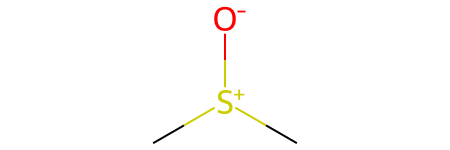

In [11]:
rdMolStandardize.Cleanup(mol1)

[00:56:42] Initializing MetalDisconnector
[00:56:42] Running MetalDisconnector
[00:56:42] Initializing Normalizer
[00:56:42] Running Normalizer
[00:56:42] Rule applied: Sulfoxide to -S+(O-)-


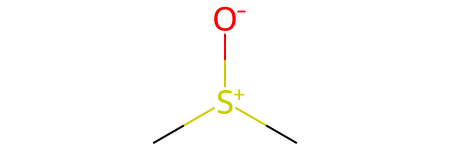

In [12]:
rdMolStandardize.Cleanup(mol2)

Note que o RDKit Mol original não é modificado:

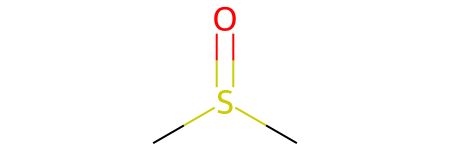

In [13]:
mol2

Portanto, é necessário atribuir o *output* a uma nova variável se quiser continuar trabalhando com o RDKit Mol padronizado:

In [14]:
new_mol2 = rdMolStandardize.Cleanup(mol2)

[00:56:42] Initializing MetalDisconnector
[00:56:42] Running MetalDisconnector
[00:56:42] Initializing Normalizer
[00:56:42] Running Normalizer
[00:56:42] Rule applied: Sulfoxide to -S+(O-)-


`Normalize()` corrige grupos funcionais e normaliza cargas. Neste exemplo, o nitrobenzeno, no qual o grupo nitro foi desenhado com cinco ligações, é corrigido:

[00:56:43] Initializing Normalizer
[00:56:43] Running Normalizer


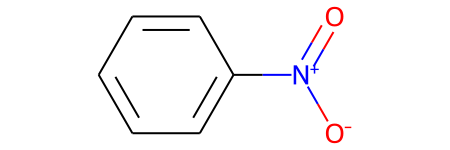

In [15]:
rdMolStandardize.Normalize(Chem.MolFromSmiles('O=N(C1=CC=CC=C1)=O'))

`MetalDisconnector()` remove ligações covalentes envolvendo metais:

[00:56:43] Initializing MetalDisconnector
[00:56:43] Running MetalDisconnector
[00:56:43] Removed covalent bond between Na and O


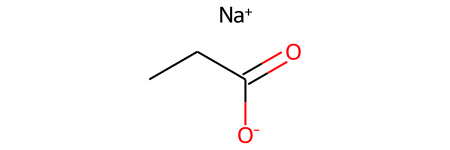

In [16]:
md = rdMolStandardize.MetalDisconnector()
md.Disconnect(Chem.MolFromSmiles("CCC(=O)O[Na]"))

`rdMolStandardize.LargestFragmentChooser()` seleciona o maior fragmento em um SMILES contendo diversos compostos:

[00:56:43] Running MetalDisconnector
[00:56:43] Removed covalent bond between Na and O
[00:56:43] Running LargestFragmentChooser
[00:56:43] Fragment: CCC(=O)[O-]
[00:56:43] New largest fragment: CCC(=O)[O-] (10)
[00:56:43] Fragment: [Na+]


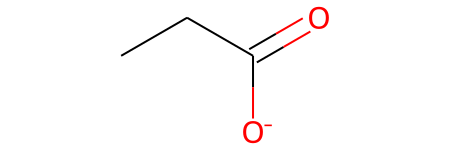

In [17]:
mol = md.Disconnect(Chem.MolFromSmiles("CCC(=O)O[Na]"))

lfc = rdMolStandardize.LargestFragmentChooser()
lfc.choose(mol)

`rdMolStandardize.FragmentParent()` é similar, mas usa automaticamente o método `rdMolStandardize.Cleanup()`

[00:56:43] Running MetalDisconnector
[00:56:43] Removed covalent bond between Na and O
[00:56:43] Running FragmentRemover
[00:56:43] Removed fragment: sodium


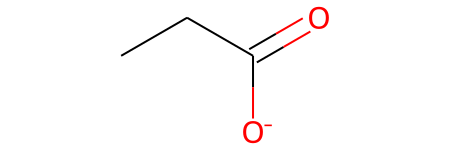

In [18]:
mol = md.Disconnect(Chem.MolFromSmiles("CCC(=O)O[Na]"))

fr = rdMolStandardize.FragmentRemover()
fr.remove(mol)

O método `rdMolStandardize.ChargeParent()` é a versão "sem cargas" da `FragmentParent()`. Envolve selecionar o fragmento principal e aplicar `Neutralize()` e `Reionize()`.

[00:56:43] Initializing MetalDisconnector
[00:56:43] Running MetalDisconnector
[00:56:43] Initializing Normalizer
[00:56:43] Running Normalizer
[00:56:43] Running LargestFragmentChooser
[00:56:43] Fragment: Cl
[00:56:43] New largest fragment: Cl (2)
[00:56:43] Fragment: [Na+]
[00:56:43] Fragment: O=C([O-])c1ccccc1
[00:56:43] New largest fragment: O=C([O-])c1ccccc1 (14)
[00:56:43] Fragment: O
[00:56:43] Running Uncharger
[00:56:43] Removed negative charge.
[00:56:43] Initializing MetalDisconnector
[00:56:43] Running MetalDisconnector
[00:56:43] Initializing Normalizer
[00:56:43] Running Normalizer


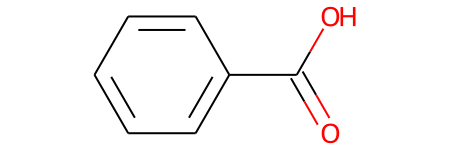

In [19]:
mol = Chem.MolFromSmiles("[Na+].O=C([O-])c1ccccc1.O.Cl")
rdMolStandardize.ChargeParent(mol)

O Notebook do RDKit ainda está incompleto e não discute como tratar tautômeros, mas em um [post no blog do RDKit](http://rdkit.blogspot.com/2020/01/trying-out-new-tautomer.html) é descrito o funcionamento das funções para tratar tautômeros. As etapas são as seguintes:

1. Enumere todos os tautômeros possíveis usando regras de transformação.
2. Use o sistema de *scoring* (pontuação) para determinar o tautômero canônico.
3. O tautômero canônico deve ser “razoável” do ponto de vista químico, mas não é garantido que seja o mais energeticamente favorável.

## Exemplo de função completa para padronização: Oxford Protein Informatics Group

A função abaixo foi descrita no [post no blog do Oxford Protein Informatics Group](https://www.blopig.com/blog/2022/05/molecular-standardization/), tendo sido baseada em um [Notebook](https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb) do criador do RDKit. Ela implementa todas as etapas de padronização disponíveis no RDKit. 

A função parece grande porque disponibiliza a opção de escrever as etapas completadas usando o parâmetro `verbose`, mas realiza essas cinco etapas:
1. `Cleanup()`
2. `FragmentParent()`
3. `Uncharger()`
4. `TautomerEnumerator()` e `Canonicalize()`
5. `Chem.MolToSmiles()`

Alguns comentários:

Acredito que seria possível unir as etapas 2 e 3 usando `rdMolStandardize.ChargeParent()`, mas optei por deixar como descrita originalmente.

A etapa 4 garante que apenas um tautômero será selecionado e que sempre o mesmo tautômero será selecionado. Note, porém, que não há garantia de que o tautômero selecionado será o mais adequado para seu modelo. Por exemplo, pode ser que seu composto apresente tautomeria ceto-enólica, e que a forma enol seja a bioativa, mas que o *pipeline* selecione a forma ceto. Caso seu conjunto de dados apresente essas questões, é recomendável visualizar as moléculas após a padronização para garantir sua correta descrição.

A etapa 5 garante que a representão final será a canônica do RDKit.

A função descrita neste [post do blog Bitsilla](https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/) é similar a essa, por isso não vou mostrá-la aqui.

In [20]:
from rdkit.Chem.MolStandardize import rdMolStandardize


def standardize_mol(mol, verbose=False):
    """
    Padroniza o RDKit Mol, seleciona o fragmento principal, remove a carga,
    então enumera todos os tautômeros.
    Se "verbose=True", uma explicação das etapas e das estruturas da molécula
    conforme é padronizada será produzida.
    """
    
    # remove Hs, desconecta metais, normaliza e reioniza a estrutura
    clean_mol = rdMolStandardize.Cleanup(mol) 
    if verbose:
        print('Etapa: Removendo Hs, desconectando metais, normalizando e reionizando a estrutura')
        draw_mol_with_SVG(clean_mol)

    # Caso o SMILES possua mais de uma estrutura, seleciona o fragmento principal
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    if verbose:
        print('Etapa: Selecionando o fragmento principal')
        draw_mol_with_SVG(parent_clean_mol)

    # Tenta neutralizar a estrutura
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    if verbose:
        print('Etapa: Neutralizando a estrutura')
        draw_mol_with_SVG(uncharged_parent_clean_mol)

    # Seleciona tautômero com maior score, segundo o RDKit
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    if verbose:
        print('Etapa: Selecionando tautômero de maior score')
        draw_mol_with_SVG(taut_uncharged_parent_clean_mol)
    assert taut_uncharged_parent_clean_mol != None
    
    if verbose: 
        print(Chem.MolToSmiles(taut_uncharged_parent_clean_mol))
    return taut_uncharged_parent_clean_mol


def standardize_smiles(smiles, verbose=False):
    """
    Padroniza a string SMILES usando standardize_mol()
    Retorna: SMILES
    """
    if verbose: print(smiles)
    std_mol = standardize_mol(Chem.MolFromSmiles(smiles), verbose=verbose)
    return Chem.MolToSmiles(std_mol)

# Para usar o argumento verbose=True, os seguintes imports são 
# necessários para que a função draw_mol_with_SVG funcione:

# import rdkit
# from rdkit.Chem import AllChem
# from rdkit.Chem import Draw # to draw molecules
# from rdkit.Chem.Draw import IPythonConsole # to draw inline in iPython
# from rdkit.Chem import rdDepictor  # to generate 2D depictions of molecules
# from rdkit.Chem.Draw import rdMolDraw2D # to draw 2D molecules using vectors

# Essa função desenha a estrutura
def draw_mol_with_SVG(mol, molSize=(450,150)):
    """Use SVG para desenhar um RDKit Mol."""
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():        
        rdDepictor.Compute2DCoords(mc) # Compute 2D coordinates
    # Initialize the drawer with the size
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc) # Draw the molcule
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText() # Get the SVG string
    display(SVG(svg.replace('svg:',''))) # Fix the SVG string and display

# O módulo ChEMBL_Structure_Pipeline

Os responsáveis pelo banco de dados de estruturas químicas ChEMBL disponibilizaram o código usado por eles para padronizar as estruturas químicas antes de adicioná-las ao website. O pacote, chamado `chembl_structure_pipeline` pode ser baixado usando `pip` ou `conda` e usa funcionalidades do RDKit.

Os autores destacam três etapas para a padronização dos SMILES:

1. **Check**: Identifica e valida estruturas problemáticas antes de serem adicionadas ao banco de dados

2. **Standardize**: Padroniza estruturas químicas de acordo com um conjunto de regras predefinidas do ChEMBL 

3. **GetParent**: Gera estruturas principais de compostos multicomponentes com base em um conjunto de regras e em uma lista predefinida de sais e solventes

**Importante:** Esse é um código usado principalmente para estruturas orgânicas, e pode não ser sempre a melhor escolha para todos os usos. Além disso, tautômeros não são considerados.

Artigo descrevendo o pacote: [An open source chemical structure curation pipeline using RDKit](https://doi.org/10.1186/s13321-020-00456-1)

Página do GitHub do projeto: https://github.com/chembl/ChEMBL_Structure_Pipeline

## Checker

Identifica problemas e valida estruturas. Requer um arquivo no formato **molblock** como *input* e retorna um valor de *penalty score* que vai de 1 a 7, com o 7 representando um estrutura inválida, e 5 ou 6 representando compostos que devem ser verificados manualmente.

In [21]:
from chembl_structure_pipeline import checker

[00:56:43] Initializing Normalizer


In [22]:
# Para ver todas as opções:
# help(checker)

In [23]:
o_molblock = """ 
  Mrv1810 02151908462D           
 
  4  3  0  0  0  0            999 V2000 
    2.2321    4.4196    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0 
    3.0023    4.7153    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0 
    1.4117    4.5059    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0 
    1.9568    3.6420    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0 
  1  2  1  1  0  0  0 
  1  3  1  0  0  0  0 
  1  4  1  0  0  0  0 
M  END 
"""

issues = checker.check_molblock(o_molblock)
issues

((5, 'InChi_RDKit/Mol stereo mismatch'),)

In [24]:
# Usando o Checker com SMILES
smi = "O=N(C1=CC=CC=C1)=O"
mol = Chem.MolFromSmiles(smi)
mb = Chem.MolToMolBlock(mol)

issues = checker.check_molblock(mb)
issues

((2, 'InChI: Charges were rearranged'),)

## Standardizer

Padroniza estruturas químicas de acordo com um extenso conjunto de regras, definido no artigo citado acima. É possível usar os formatos RDKit Mol e molblock como *input*.

In [25]:
from chembl_structure_pipeline import standardizer

In [26]:
# Para ver todas as opções:
# help(standardizer)

In [27]:
# Gerando SMILES padronizado a partir de SMILES
smi = "CCC(=O)O[Na].[OH2]"
mol = Chem.MolFromSmiles(smi)

std_mol = standardizer.standardize_mol(mol)
std_smi = Chem.MolToSmiles(std_mol)

std_smi

[00:56:43] Running Normalizer
[00:56:43] Running Uncharger


'CCC(=O)[O-].O.[Na+]'

Veja que o contraíon e o solvente não foram removidos

In [28]:
smi = "O=N(C1=CC=CC=C1)=O"
mol = Chem.MolFromSmiles(smi)

std_mol = standardizer.standardize_mol(mol)
std_smi = Chem.MolToSmiles(std_mol)

std_smi

[00:56:43] Running Normalizer
[00:56:43] Running Uncharger


'O=[N+]([O-])c1ccccc1'

In [29]:
# Também funciona com molblock

o_molblock = """
  Mrv1810 07121910172D          

  4  3  0  0  0  0            999 V2000
   -2.5038    0.4060    0.0000 C   0  0  3  0  0  0  0  0  0  0  0  0
   -2.5038    1.2310    0.0000 O   0  5  0  0  0  0  0  0  0  0  0  0
   -3.2182   -0.0065    0.0000 N   0  3  0  0  0  0  0  0  0  0  0  0
   -1.7893   -0.0065    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  1  3  1  0  0  0  0
  1  4  1  4  0  0  0
M  CHG  2   2  -1   3   1
M  END
"""

std_molblock = standardizer.standardize_molblock(o_molblock)
print(std_molblock)


     RDKit          2D

  4  3  0  0  0  0  0  0  0  0999 V2000
   -2.5038    0.4060    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5038    1.2310    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -3.2182   -0.0065    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7893   -0.0065    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  1  3  1  0
  1  4  1  0
M  END



[00:56:43] Running Normalizer
[00:56:43] Running Uncharger
[00:56:43] Removed negative charge.
[00:56:43] Removed positive charge.


## GetParent

Remove [contraíons](https://github.com/chembl/ChEMBL_Structure_Pipeline/blob/master/chembl_structure_pipeline/data/salts.smi), [solventes](https://github.com/chembl/ChEMBL_Structure_Pipeline/blob/master/chembl_structure_pipeline/data/solvents.smi) e isótopos. Neutraliza a molécula resultante quando possível (uma exceção são os compostos com nitrogênio quaternário).

A função retorna uma tupla com dois valores: o primeiro é a molécula principal, e o segundo, tudo o que foi removido.

In [30]:
mol = Chem.MolFromSmiles("C1(C2C[NH2+]CC2)=CC=CC=C1.[Cl-]")

parent_mol, removed_species = standardizer.get_parent_mol(mol)

[00:56:43] Running Uncharger
[00:56:43] Removed positive charge.
[00:56:43] Running Uncharger
[00:56:43] Removed positive charge.


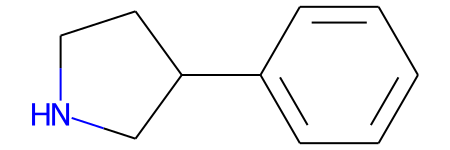

In [31]:
parent_mol

In [32]:
removed_species

False

**Importante**: Veja o exemplo a seguir, que não funciona da forma que poderíamos esperar a princípio (remoção do sódio e neutralização do benzoato a ácido benzoico):

In [33]:
mol = Chem.MolFromSmiles("O=C([O-])c1ccccc1.[Na+]")

parent_mol, removed_species = standardizer.get_parent_mol(mol)

[00:56:43] Running Uncharger
[00:56:43] Removed negative charge.
[00:56:43] Running Uncharger
[00:56:43] Running Uncharger


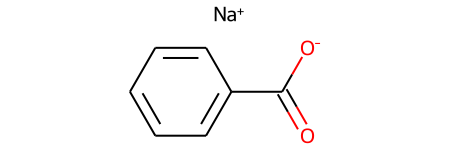

In [34]:
parent_mol

In [35]:
removed_species

False

Isso ocorre porque tanto o benzoato quanto o sódio são incluídos na [lista de sais/contraíons](https://github.com/chembl/ChEMBL_Structure_Pipeline/blob/master/chembl_structure_pipeline/data/salts.smi) do ChEMBL. Dessa forma, como as duas espécies são removidas pelo *pipeline*, os autores optaram por retornar o composto da forma que foi apresentado. Na função sugerida no próximo item, mostro como resolver essa questão.

In [36]:
# Também funciona com molblock

o_molblock = """
  Mrv1810 07121910262D          

  3  1  0  0  0  0            999 V2000
   -5.2331    1.1053    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.5186    1.5178    0.0000 N   0  3  0  0  0  0  0  0  0  0  0  0
   -2.8647    1.5789    0.0000 Cl  0  5  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
M  CHG  2   2   1   3  -1
M  END
"""

parent_molblock, _ = standardizer.get_parent_molblock(o_molblock)

print(parent_molblock)


     RDKit          2D

  2  1  0  0  0  0  0  0  0  0999 V2000
   -5.2331    1.1053    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.5186    1.5178    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
M  END



[00:56:43] Running Uncharger
[00:56:43] Removed positive charge.
[00:56:43] Running Uncharger
[00:56:43] Removed positive charge.


# Exemplo de função completa para padronização com o ChEMBL_Structure_Pipeline

Este [artigo](https://www.insilico.jp/blog/2021/11/16/chembl-structure-pipeline/) usa uma abordagem que, segundo os autores, funcionou melhor que o *pipeline* do ChEMBL, e pode ser aplicada diretamente a objetos RDKit Mol. Ela também resolve a questão de compostos como o benzoato de sódio apresentado anteriormente, mas não padroniza tautômeros. 

Dessa forma, adaptei a parte do código que interessa, adicionando:
- a opção de retornar objeto RDKit Mol ou SMILES
- a opção de ignorar centros estereoquímicos
- a padronização de formas tautoméricas usando o RDKit

Assim, nos beneficiamos das regras usadas no *pipeline* de curagem do ChEMBL e obtemos uma representação canônica para tautômeros.

In [37]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from chembl_structure_pipeline import standardizer

def new_standardize_mol(smiles, return_mol=True):
    """
    Input = SMILES
    return_mol: indica se a função vai retornar RDKit Mol (True) ou SMILES (False)
    """
    try:
        molecule = Chem.MolFromSmiles(smiles)
    except:
        return
    
    try:
        # Aplicar standardize_mol
        std1_mol = standardizer.standardize_mol(molecule)
        # Selecionar o maior fragmento
        desalter = rdMolStandardize.LargestFragmentChooser()
        desalt_mol = desalter.choose(std1_mol)
        # Aplicar standardize_mol ao maior fragmento
        std2_mol = standardizer.standardize_mol(desalt_mol)  
        # Selecionar tautômero com maior score
        te = rdMolStandardize.TautomerEnumerator()
        taut_uncharged_parent_clean_mol = te.Canonicalize(std2_mol)
        # Opcional: remover informação sobre estereoquímica
        taut_smi = Chem.MolToSmiles(taut_uncharged_parent_clean_mol, isomericSmiles=False)  
        # Pelo que observei, essa SMILES string ainda pode falhar a conversão a RDKit Mol,
        # por isso, o código abaixo é necessário:
        final_smi = Chem.MolToSmiles(Chem.MolFromSmiles(taut_smi))
        
        if not final_smi:
            return
        
        if return_mol:
            return Chem.MolFromSmiles(final_smi)
        else:
            return final_smi
    
    except Exception as e: 
        print(e)
        print("Erro, falha na padronização")
        return


[00:56:43] Running Normalizer
[00:56:43] Running Uncharger
[00:56:43] Running LargestFragmentChooser
[00:56:43] Fragment: O
[00:56:43] New largest fragment: O (3)
[00:56:43] Fragment: CCC(=O)[O-]
[00:56:43] New largest fragment: CCC(=O)[O-] (10)
[00:56:43] Fragment: [Na+]
[00:56:43] Running Normalizer
[00:56:43] Running Uncharger
[00:56:43] Removed negative charge.


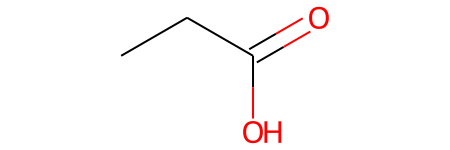

In [38]:
# Exemplo de uso: propionato de sódio com água
smi = "CCC(=O)O[Na].[OH2]"

new_standardize_mol(Chem.MolFromSmiles(smi))

Se quiser suprimir esses avisos em vermelho do RDKit, pode usar:

In [39]:
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

# Os cinco níveis de "avisos" do RDKit:
# DEBUG, INFO, WARNING, ERROR, CRITICAL
# Com o código acima, somente ERROR ou CRITICAL serão mostrados

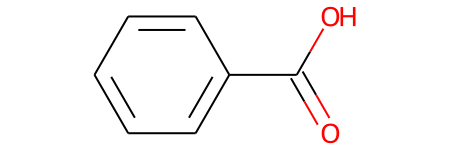

In [40]:
# Exemplo de uso: benzoato de sódio
smi = "O=C([O-])c1ccccc1.[Na+]"

new_standardize_mol(Chem.MolFromSmiles(smi))

In [41]:
# Exemplo de uso: tautômeros - 2-pyridone e 2-hydroxypyridine
smi1 = "C1=CC=CNC(=O)1"
smi2 = "Oc1ccccn1"

# Usando a opção de converter as estruturas a SMILES
new_smi1 = new_standardize_mol(Chem.MolFromSmiles(smi1), return_mol=False)
new_smi2 = new_standardize_mol(Chem.MolFromSmiles(smi2), return_mol=False)

new_smi1 == new_smi2

True

Nota: Também é possível usar `%%capture` na primeira linha da célula para suprimir todos os *outputs*. Isso também vai suprimir os erros e exceções, mas você pode verificar cada um individualmente depois. Exemplo:

%%capture
for smi in smi_list:
    new_smiles = new_standardize_mol(Chem.MolFromSmiles(smi))
    ...

# PubChem

O PubChem também disponibiliza seu *pipeline* de padronização, porém, não há um módulo em Python disponível, sendo necessário submeter os compostos a um *webservice*. Se tiver interesse, esse é o link para mais informações, em inglês: https://pubchem.ncbi.nlm.nih.gov/docs/standardization-service

# Knime

Finalmente, deixo aqui também a referência para um *pipeline* de padronização no Knime, um programa muito usado por químicos com menos familiaridade com linguagens de programação: https://hub.knime.com/knime/spaces/Workflow%20Snippets/latest/Standardizing%20Molecular%20Structures~ZfDa-vucSUTJGo2C